<a href="https://colab.research.google.com/github/arashabzd/soft-margin-svm-cvxopt/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft Margin SVM Theory and Implementation with CVXOPT

In [0]:
import numpy as np
import cvxopt as cvx
import matplotlib.pyplot as plt

In [0]:
def generate_linear_separable_data(n):
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, n//2)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, n//2)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def generate_non_linear_separable_data(n):
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, n//4)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, n//4)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, n//4)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2


## A. Formulating Primal Problem as a Quadratic Program

---
\begin{align*} 
& \text{Soft Margin SVM primal problem:} \\
& \\
& \text{minimize}_{w, b, \xi} \quad \frac{1}{2} ||w||^2 + C \sum_{i=1}^n \xi_i \\
& \text{subject to} \quad y_i (w^T x_i + b) \geq 1 - \xi_i \quad (i = 1, ..., n) \\
& \\
& \text{To make the primal problem in form of a quadratic program we put all optimization variables $(w, b, \xi)$ in one variable $u$:} \\ 
& \\ 
& u = [w, b, \xi]^T \in \Re^{(d + 1 + n)} \\ 
& \\ 
& P = \begin{bmatrix} 
    I & 0 & 0 \\ 
    0 & 0 & 0 \\ 
    0 & 0 & 0 
\end{bmatrix} \in \Re^{(d + 1 + n) \times (d + 1 + n)} \\ 
& \\ 
& q = [0, 0, C]^T \in \Re^{(d + 1 + n)} \\ 
& \\ 
& \min_{w, b, \xi} \frac{1}{2} ||w||^2 + C \sum_{i=1}^n \xi_i = \min_u \frac{1}{2} u^T P u + q^T u \qquad \text{(QP objective)} \\ 
& \\ 
& y_i (w^T x_i + b) \geq 1 - \xi_i \quad (i = 1, ..., n) \implies \text{diag}(y)(Xw + b1) \succeq 1 - \xi \implies -\text{diag}(y)Xw - by - I \xi \preceq -1 \\
& \\ 
& \xi \succeq 0 \implies -\xi \preceq 0 \\ 
& \\ 
& G = \begin{bmatrix} 
    -\text{diag}(y)X & -y & -I \\ 
    0 & 0 & -I 
\end{bmatrix} \in \Re^{(n + n) \times (d + 1 + n + n)} \\ 
& \\ 
& h = [-1, 0]^T \in \Re^{(n + n)} \\ 
& \\ 
& y_i (w^T x_i + b) \geq 1 - \xi_i \quad (i = 1, ..., n), \quad \xi \succeq 0 \implies Gu \preceq h \qquad \text{(inequality constraint)} \\ 
& \\ 
& \text{The equivalent quadtratic program form of primal problem problem is:} \\ 
& \\ 
& \text{minimize}_u \quad \frac{1}{2} u^T P u + q^T u \\ 
& \text{subject to} \quad Gu \preceq h \end{align*}

---

## B. Solving Primal Problem

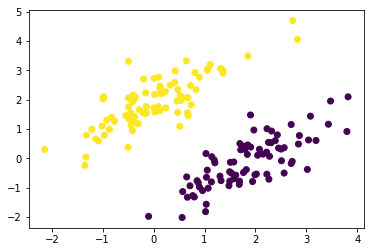

In [0]:
d = 2 # dimession
n = 200 # total samples
p = .2 # test fraction
n_test = int(p * n) # number of training samples
n_train = n - n_test # number of test samples 

X1, y1, X2, y2 = generate_linear_separable_data(n)

prmt = np.random.permutation(n)
X = np.vstack([X1, X2])[prmt]
y = np.concatenate([y1, y2])[prmt]

X_test = X[:n_test]
y_test = y[:n_test]
X_train = X[n_test:]
y_train = y[n_test:]

plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.show()

In [0]:
C = 1.
P = np.zeros((d + 1 + n_train, d + 1 + n_train))
P[:d, :d] = np.eye(d)
P = cvx.matrix(P)

q = C * np.concatenate((np.zeros(d + 1), np.ones(n_train)))
q = cvx.matrix(q)

G = np.zeros((n_train + n_train, d + 1 + n_train))
G[:n_train, :d] = -np.diag(y_train) @ X_train
G[:n_train, d] = -y_train
G[:n_train, -n_train:] = -np.eye(n_train)
G[n_train:, -n_train:] = -np.eye(n_train)
G = cvx.matrix(G)

h = np.concatenate((-np.ones(n_train), np.zeros(n_train)))
h = cvx.matrix(h)


solution = cvx.solvers.qp(P, q, G, h)


     pcost       dcost       gap    pres   dres
 0: -1.4650e+02  3.0275e+02  2e+03  4e+00  3e+01
 1:  1.0888e+02 -9.1039e+01  3e+02  4e-01  3e+00
 2:  1.5936e+01 -7.0225e+00  3e+01  3e-02  3e-01
 3:  5.2859e+00 -2.2299e-01  6e+00  8e-03  6e-02
 4:  3.2447e+00  1.3053e+00  2e+00  2e-03  1e-02
 5:  2.5456e+00  1.8872e+00  7e-01  2e-04  1e-03
 6:  2.1875e+00  2.1570e+00  3e-02  2e-06  1e-05
 7:  2.1699e+00  2.1696e+00  4e-04  2e-08  2e-07
 8:  2.1697e+00  2.1697e+00  4e-06  2e-10  2e-09
 9:  2.1697e+00  2.1697e+00  4e-08  2e-12  2e-11
Optimal solution found.


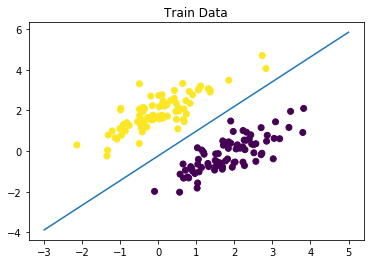

In [0]:
w = np.array(solution['x'][:2])
b = np.array(solution['x'][2])

x1 = np.linspace(-3, 5, 100)
x2 = (-w[0] * x1 - b) / w[1]
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.plot(x1, x2)
plt.title('Train Data')
plt.show()

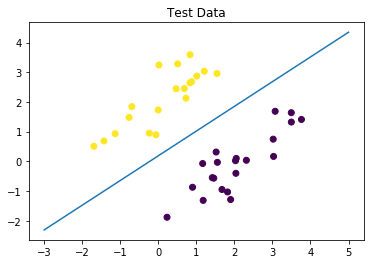

In [0]:
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.plot(x1, x2)
plt.title('Test Data')
plt.show()

## C. Does strong duality hold?

Yes. P is positive semi-definite (diagonal matrix with positive diagonal elements) therefore problem is convex. All inequality constraints are linear therefore slater condition hold if the problem is feasible and that means strong duality holds.

## D. KKT Conditions

---
\begin{align*}
& \text{Lagrangian function:} \\
& L(w, b, \xi, \alpha, \beta) = \frac{1}{2}||w||^2 + C \sum_i \xi_i + \sum_i \alpha_i(1 - \xi_i - y_i(w^Tx_i+b)) - \sum_i \beta_i \xi_i \\
& \\
& \text{KKT Conditions:} \\
& \text{1. primal constraints:} \\
& \qquad \text{1.1} \quad \xi \succeq 0 \\
& \qquad \text{1.1} \quad y_i(w^Tx_i+b) \geq 1 - \xi_i \quad (i = 1, ... ,n) \\
& \text{2. dual constraints:} \\
& \qquad \text{2.1} \quad \alpha \succeq 0 \\
& \qquad \text{2.1} \quad \beta \succeq 0 \\
& \text{3. complementary slackness:} \\ 
& \qquad \text{3.1} \quad \alpha_i(1 - \xi_i - y_i(w^Tx_i+b)) = 0 \quad (i = 1, ..., n) \\
& \qquad \text{3.2} \quad \beta_i \xi_i=0 \quad (i = 1, ..., n) \\
& \text{4.} \\ 
& \qquad \text{4.1} \quad \bigtriangledown_w L = 0 \implies w - \sum_i \alpha_i y_i x_i = 0 \implies w = \sum_i \alpha_i y_i x_i \\
& \qquad \text{4.2} \quad \frac{\partial L}{\partial b} = 0 \implies \sum_i \alpha_i y_i = 0 \\
& \qquad \text{4.3} \quad \frac{\partial L}{\partial \xi_i} = C - \alpha_i - \beta_i = 0 
\end{align*}

---

## E. Dual Problem

---
\begin{align*}
& \text{substituting 4.1 into lagrangian:} \\
& L(\sum_i \alpha_i y_i x_i, b, \xi, \alpha, \beta) \\ 
& \quad = \frac{1}{2} (\sum_i \alpha_i y_i x_i^T)  (\sum_j \alpha_j y_j x_j) + C \sum_i \xi_i 
+ \sum_i \alpha_i(1 - \xi_i - y_i(\sum_j \alpha_j y_j x_j^Tx_i+b)) - \sum_i \beta_i \xi_i \\
& \quad = \frac{1}{2} (\sum_i \alpha_i y_i x_i^T)  (\sum_j \alpha_j y_j x_j) + C \sum_i \xi_i 
+ \sum_i \alpha_i - \sum_i \alpha_i \xi_i - sum_i \alpha_i y_i(\sum_j \alpha_j y_j x_j^Tx_i+b) - \sum_i \beta_i \xi_i \\
& \quad =^{4.3} \frac{1}{2} (\sum_i \alpha_i y_i x_i^T)  (\sum_j \alpha_j y_j x_j)
+ \sum_i \alpha_i - \sum_i \sum_j(\alpha_i y_i\alpha_j y_j x_j^Tx_i+b) \\
& \quad =^{4.2} \sum_i \alpha_i - \frac{1}{2} \sum_i \sum_j(\alpha_i y_i\alpha_j y_j x_j^Tx_i+b) \\
& \quad = 1^T \alpha - \frac{1}{2} \alpha^T \text{diag}(y) X X^T \text{diag}(y) \alpha \\
& \\
& \text{dual fuction is independent of $\beta$ therefore we can write dual problem as:}\\
& \implies^{4.3} C - \alpha_i = \beta_i \implies^{2.1} C - \alpha_i \geq 0 \implies \alpha_i \leq C \implies^{2.1} 0 \leq \alpha_i \leq C \\
& \\
& \text{maximize}_{\alpha} \quad 1^T \alpha - \frac{1}{2} \alpha^T \text{diag}(y) X X^T \text{diag}(y) \alpha \\
& \text{subject to} \quad  0 \leq \alpha_i \leq C \\
& \qquad\qquad \sum_i \alpha_i y_i = 0
\end{align*}

---

## F. Optimal values

---
\begin{align*}
& w = \sum_i \alpha_i y_i x_i \\
& b = y_i - w^T x_i \qquad \text{for some i such that $\alpha_i > 0$ (Support Vector)} \\
& \text{* In practice it is recommended to take the average for all support vectors}
\end{align*}

---

## G. Formulating Dual Problem as a Quadratic Program

---
\begin{align*}
& \text{minimize}_{\alpha} \quad \frac{1}{2} \alpha^T \text{diag}(y) X X^T \text{diag}(y) \alpha - 1^T \alpha\\
& \text{subject to} \quad  0 \leq \alpha_i \leq C \implies \alpha \preceq C1, \quad -\alpha \preceq 0 \\
& \qquad\qquad \sum_i \alpha_i y_i = 0 \implies y^T \alpha = 0\\
& P = \text{diag}(y) X X^T \text{diag}(y) \\
& q = -1 \\
& G = \begin{bmatrix} 
I \\
-I 
\end{bmatrix} \\
& h = [C, 0]^T \\
& A = y^T \\
& b = 0
\end{align*}

---

## H. Solving Dual Problem

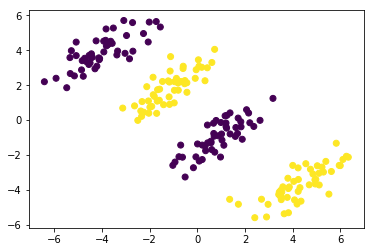

In [0]:
n = 200
p = .2
n_test = int(p * n) 
n_train = n - n_test 

X1, y1, X2, y2 = generate_non_linear_separable_data(n)

prmt = np.random.permutation(n)
X = np.vstack([X1, X2])[prmt]
y = np.concatenate([y1, y2])[prmt]

X_test = X[:n_test]
y_test = y[:n_test]
X_train = X[n_test:]
y_train = y[n_test:]

plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [0]:
cvx.solvers.options['show_progress'] = False
def rbf(x1, x2, gamma):
    x = x1 - x2
    return np.exp(-gamma * np.dot(x, x))


Cs = [1e-2, 1e-1, .5, 1]
gammas = [10, 50, 100, 500]

train_acc = []
test_acc = []
y_hats_train = []
y_hats_test = []
for C in Cs:
    train_acc_C = []
    test_acc_C = []
    y_hat_train_C = []
    y_hat_test_C = []
    for gamma in gammas:
        K = np.zeros((n_train, n_train))
        for i in range(n_train):
            for j in range(n_train):
                K[i, j] = rbf(X_train[i], X_train[j], gamma=gamma)

        P = np.diag(y_train) @ K @ np.diag(y_train)
        P = cvx.matrix(P)

        q = -np.ones(n_train)
        q = cvx.matrix(q)

        G = np.vstack((np.eye(n_train), -np.eye(n_train)))
        G = cvx.matrix(G)

        h = np.concatenate((C * np.ones(n_train), np.zeros(n_train)))
        h = cvx.matrix(h)

        A = cvx.matrix(y_train.reshape((1, -1)))
        b = cvx.matrix(0.0)
        cvx.solvers.options['show_progress'] = False
        solution = cvx.solvers.qp(P, q, G, h, A, b);
        
        alpha = np.array(solution['x']).flatten()
        support = alpha > 1e-6

        b = np.mean(
            [
                np.sum(
                    [
                        alpha[j] * y_train[j] * K[i, j] for j in  range(n_train)
                    ]
                ) - y_train[i] for i in range(n_train) if support[i]
            ]
        )
        predict = lambda x: np.sign(np.sum(
            [
                alpha[j] * y_train[j] * rbf(X_train[j], x, gamma=gamma) for j in  range(n_train)
            ]
        ) - b).item()
        
        y_hat_train = np.array([predict(x) for x in X_train])
        y_hat_test = np.array([predict(x) for x in X_test])
        y_hat_train_C.append(y_hat_train)
        y_hat_test_C.append(y_hat_test)
        train_acc_C.append(np.count_nonzero(y_train == y_hat_train) / n_train)
        test_acc_C.append(np.count_nonzero(y_test == y_hat_test) / n_test)
    y_hats_train.append(y_hat_train_C)
    y_hats_test.append(y_hat_test_C)
    train_acc.append(train_acc_C)
    test_acc.append(test_acc_C)

In [0]:
print('Train Accuracy:')
print('{:8}|'.format('Gamma:'), '{:10}{:10}{:10}{:10}'.format(*gammas))
print('_'*50)
[print('C = {:4}|'.format(c), '{:10}{:10}{:10}{:10}'.format(*train_acc[i])) for i, c in enumerate(Cs)];

Train Accuracy:
Gamma:  |         10        50       100       500
__________________________________________________
C = 0.01|      0.875     0.675   0.60625    0.5375
C =  0.1|        1.0       1.0       1.0       1.0
C =  0.5|        1.0       1.0       1.0       1.0
C =    1|        1.0       1.0       1.0       1.0


In [0]:
print('Test Accuracy:')
print('{:8}|'.format('Gamma:'), '{:10}{:10}{:10}{:10}'.format(*gammas))
print('_'*50)
[print('C = {:4}|'.format(c), '{:10}{:10}{:10}{:10}'.format(*test_acc[i])) for i, c in enumerate(Cs)];

Test Accuracy:
Gamma:  |         10        50       100       500
__________________________________________________
C = 0.01|        0.7       0.5       0.5     0.475
C =  0.1|       0.95     0.675       0.6     0.525
C =  0.5|      0.975     0.725     0.625     0.525
C =    1|      0.975     0.725      0.65     0.525


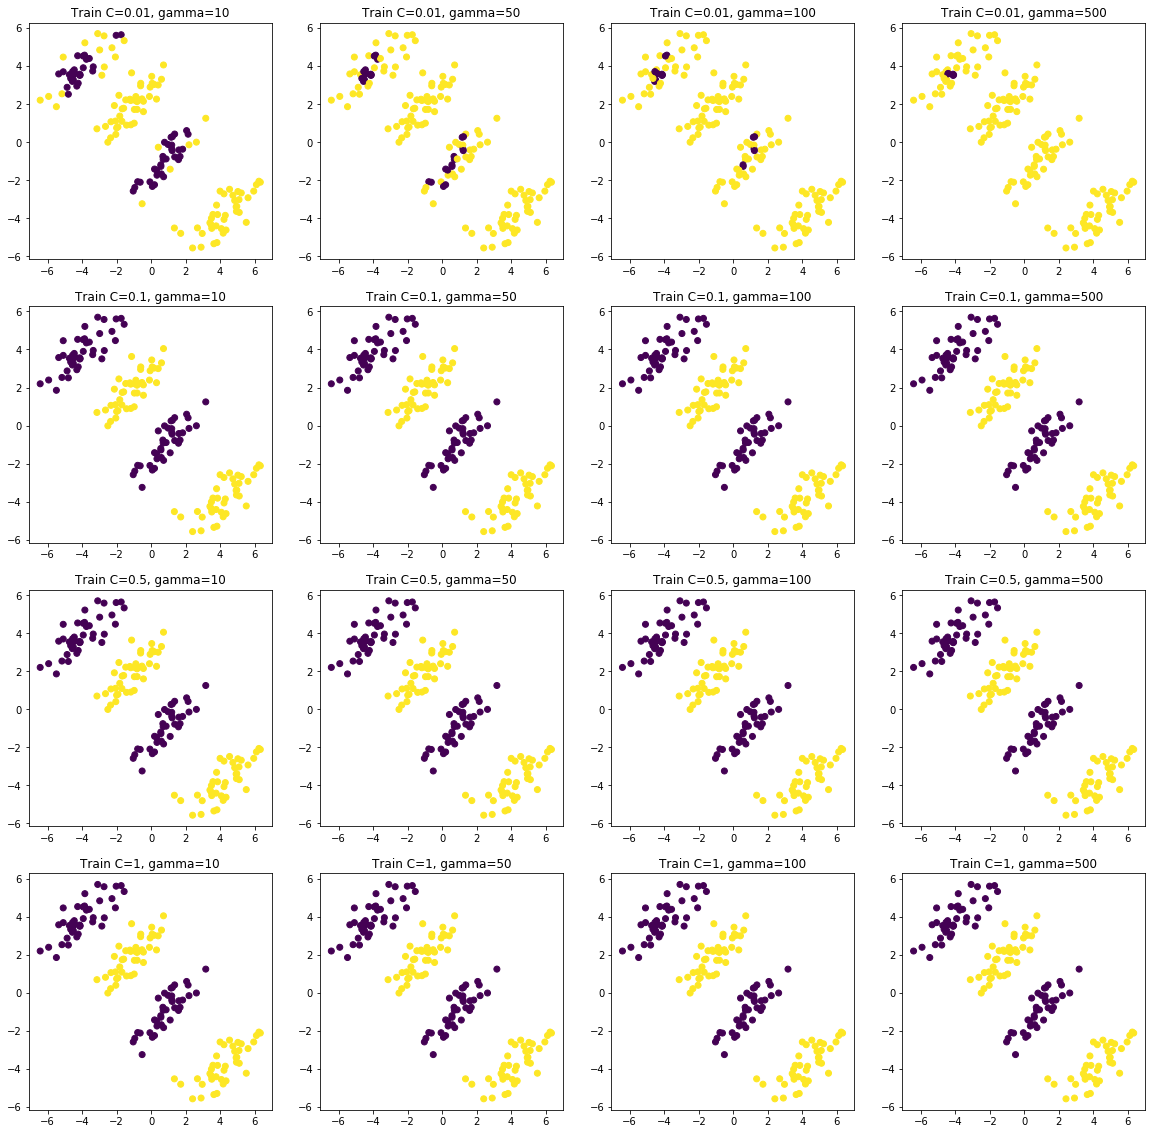

In [0]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(len(Cs), len(gammas))

for i , c in enumerate(Cs):
    for j, gamma in enumerate(gammas):
        ax[i, j].scatter(X_train[:, 0], X_train[:, 1], c=y_hats_train[i][j])
        ax[i, j].set_title('Train C={}, gamma={}'.format(c, gamma))
plt.plot();

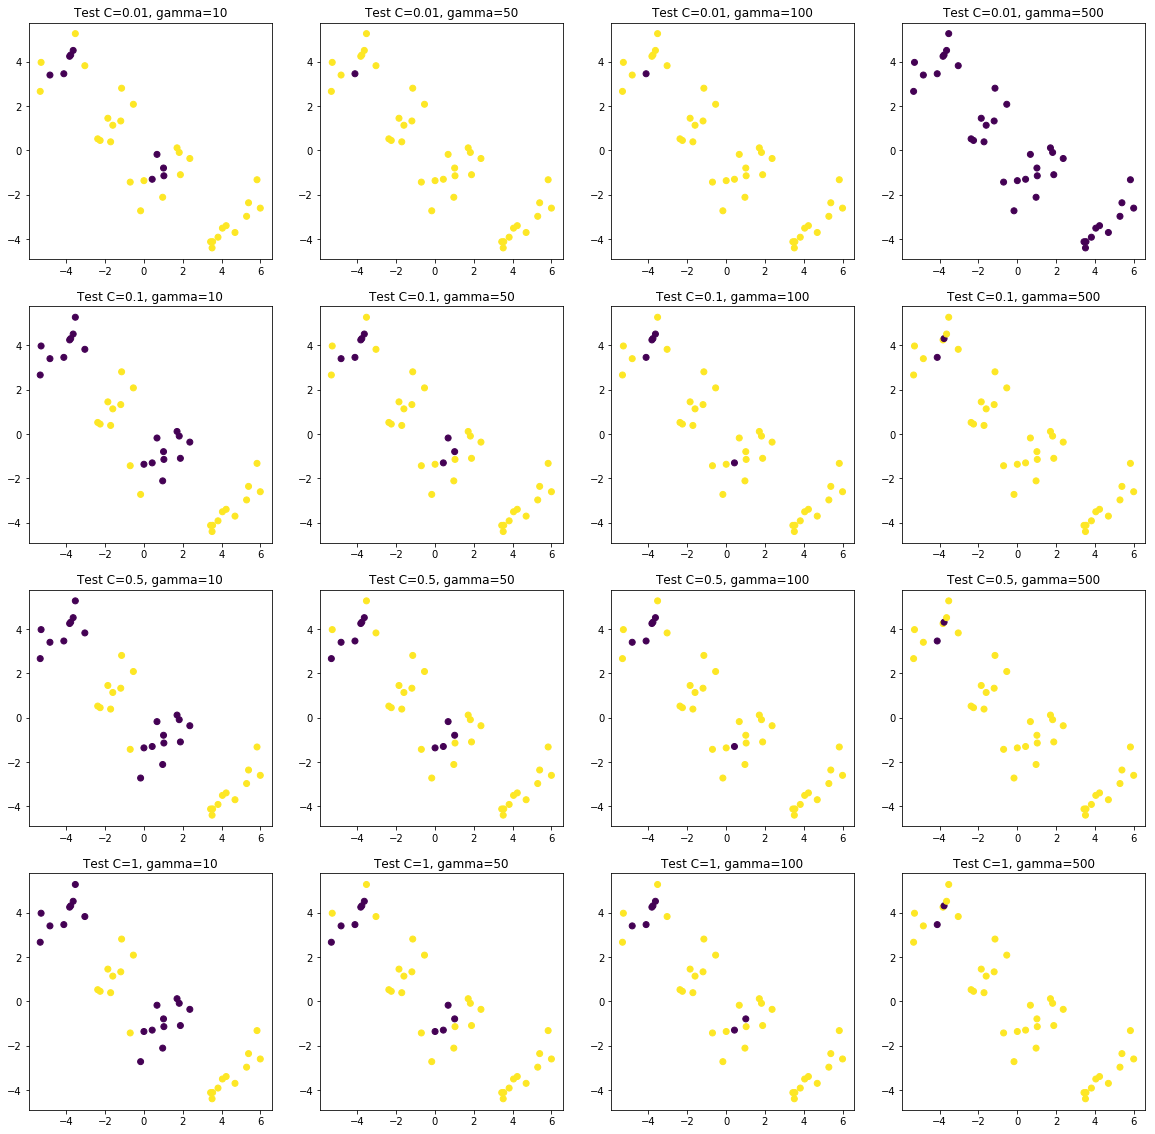

In [0]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(len(Cs), len(gammas))

for i , c in enumerate(Cs):
    for j, gamma in enumerate(gammas):
        ax[i, j].scatter(X_test[:, 0], X_test[:, 1], c=y_hats_test[i][j])
        ax[i, j].set_title('Test C={}, gamma={}'.format(c, gamma))
plt.plot();